In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('House_Rent_Dataset.csv')
df.columns = df.columns.str.replace(' ','_').str.replace('([a-z0-9])([A-Z])', r'\1_\2', regex=True).str.lower()
df.head()

,posted_on,bhk,rent,size,floor,area_type,area_locality,city,furnishing_status,tenant_preferred,bathroom,point_of_contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [3]:
df.value_counts('city')

city
Mumbai       972
Chennai      891
Bangalore    886
Hyderabad    868
Delhi        605
Kolkata      524
Name: count, dtype: int64

In [4]:
# Chennai has 75 days
df = df[df['city'] == 'Chennai']


In [5]:
df['posted_on'] = pd.to_datetime(df['posted_on'])

daily_price_index = df.groupby('posted_on')['rent'].mean().reset_index()

daily_price_index.rename(columns={"rent": "price_index"}, inplace = True)


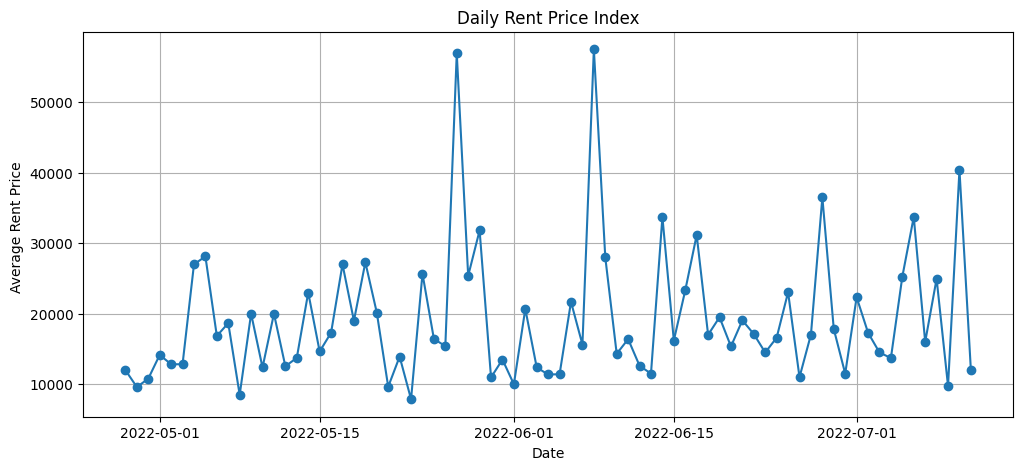

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(daily_price_index['posted_on'], daily_price_index['price_index'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Average Rent Price ')
plt.title('Daily Rent Price Index')
plt.grid(True)
plt.show()

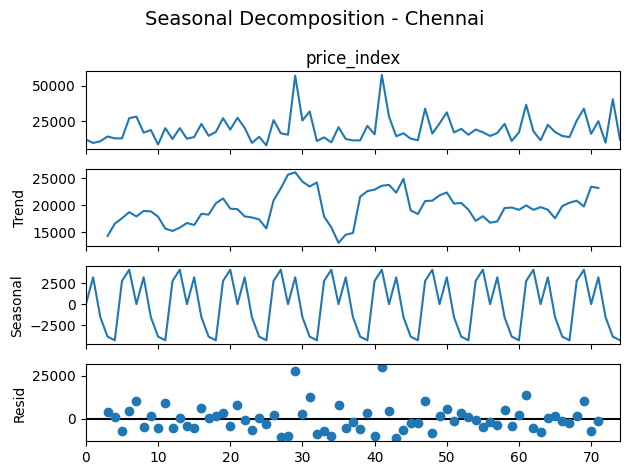

In [7]:
decomposition = seasonal_decompose(daily_price_index['price_index'].dropna(), model='additive', period=7) 
decomposition.plot()
plt.suptitle("Seasonal Decomposition - Chennai", fontsize=14)
plt.tight_layout()
plt.show()

In [8]:
result = adfuller(daily_price_index['price_index'].dropna())

results1 = adfuller(daily_price_index['price_index'].diff().dropna())

print("ADF Test on Original Series:")
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

if result[1] < 0.05:
    print("Reject the null hypothesis: The series is stationary.")
else:
    print("Fail to reject the null hypothesis: The series is non-stationary.")

print("\nADF Test on First-Differenced Series:")
print("ADF Statistic:", results1[0])
print("p-value:", results1[1])
print("Critical Values:", results1[4])

if results1[1] < 0.05:
    print("Reject the null hypothesis: The differenced series is stationary.")
else:
    print("Fail to reject the null hypothesis: The differenced series is non-stationary.")


ADF Test on Original Series:
ADF Statistic: -8.336941549896736
p-value: 3.2531459817574185e-13
Critical Values: {'1%': np.float64(-3.5219803175527606), '5%': np.float64(-2.9014701097664504), '10%': np.float64(-2.58807215485756)}
Reject the null hypothesis: The series is stationary.

ADF Test on First-Differenced Series:
ADF Statistic: -6.043950096992139
p-value: 1.3255450595154428e-07
Critical Values: {'1%': np.float64(-3.5386953618719676), '5%': np.float64(-2.9086446751210775), '10%': np.float64(-2.591896782564878)}
Reject the null hypothesis: The differenced series is stationary.


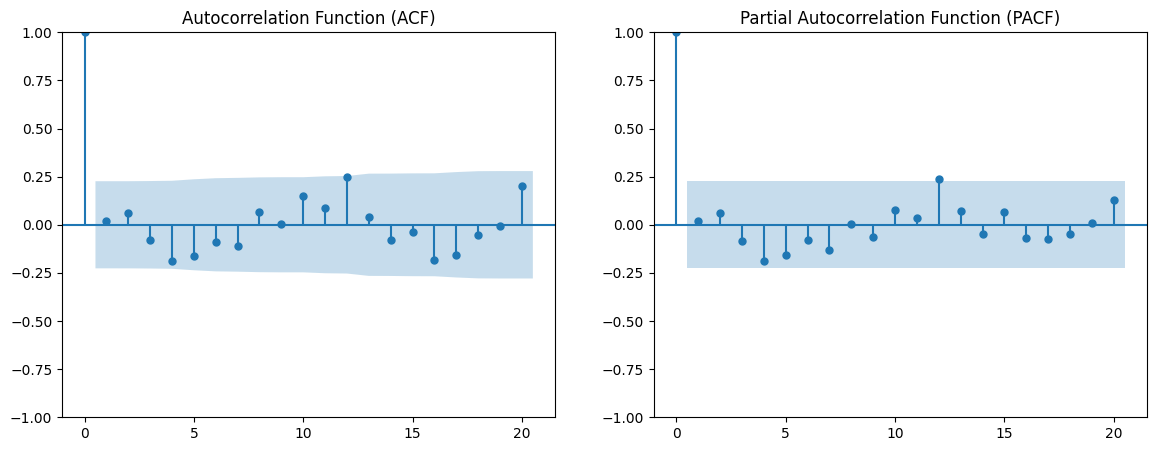

In [9]:
max_lags = 20

# Plot ACF and PACF: used to understand the p and q parameters in ARIMA(p,d,q)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(daily_price_index['price_index'], lags=max_lags, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(daily_price_index['price_index'], lags=max_lags, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

In [10]:
p = q = range(0, 3)  
d = [0] #the data is stationary

orders = list(itertools.product(p, d, q))

model_results = []

for order in orders:
    try:
        model = sm.tsa.ARIMA(daily_price_index['price_index'], order=order)
        result = model.fit()
        model_results.append((order, result.aic))
    except:
        print(f"ARIMA{order} failed.")

results_df = pd.DataFrame(model_results, columns=['Order', 'AIC']).sort_values(by='AIC')
print(results_df.head())

/Users/masha/Desktop/Data mining (texas)/Data mining/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/masha/Desktop/Data mining (texas)/Data mining/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/masha/Desktop/Data mining (texas)/Data mining/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/masha/Desktop/Data mining (texas)/Data mining/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978

       Order          AIC
0  (0, 0, 0)  1589.923826
3  (1, 0, 0)  1591.689138
1  (0, 0, 1)  1591.703274
2  (0, 0, 2)  1593.244788
6  (2, 0, 0)  1593.393681


In [11]:
p = q = range(0, 3)
d = D = range(0,1)

P = Q = range(0, 2)  # Seasonal ARIMA orders
s = [7]  # Weekly seasonality

param_grid = list(itertools.product(p, d, q, P, D, Q, s))

results = []

for params in param_grid:
    try:
        model = SARIMAX(daily_price_index['price_index'], 
                        order=(params[0], params[1], params[2]), 
                        seasonal_order=(params[3], params[4], params[5], params[6]),
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        fitted_model = model.fit(disp=False)

        # Get AIC, BIC
        aic = fitted_model.aic

        results.append([params, aic])
        
    except Exception as e:
        print(f"Model {params} failed: {e}")

results_df = pd.DataFrame(results, columns=["Params", "AIC"])
results_df.sort_values(by = 'AIC')


/Users/masha/Desktop/Data mining (texas)/Data mining/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/masha/Desktop/Data mining (texas)/Data mining/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Params,AIC
21,"(1, 0, 2, 0, 0, 1, 7)",1392.110423
33,"(2, 0, 2, 0, 0, 1, 7)",1393.008492
35,"(2, 0, 2, 1, 0, 1, 7)",1394.540936
23,"(1, 0, 2, 1, 0, 1, 7)",1395.579144
17,"(1, 0, 1, 0, 0, 1, 7)",1411.066827
29,"(2, 0, 1, 0, 0, 1, 7)",1412.810967
30,"(2, 0, 1, 1, 0, 0, 7)",1413.323693
19,"(1, 0, 1, 1, 0, 1, 7)",1414.547078
31,"(2, 0, 1, 1, 0, 1, 7)",1416.308242
27,"(2, 0, 0, 1, 0, 1, 7)",1427.744415


In [12]:
# We immediately note that the AIC and BIC for the SARIMA models are lower, so we only consider the SARIMA models for estimation

order_best_AIC = results_df.sort_values(by='AIC').head()['Params'].iloc[0]
print(order_best_AIC)

(1, 0, 2, 0, 0, 1, 7)


In [13]:
models = [order_best_AIC]
results = {}

for idx, order in enumerate(models):
    model = SARIMAX(daily_price_index['price_index'], 
                    order=(order[0], order[1], order[2]), 
                    seasonal_order=(order[3], order[4], order[5], order[6]),
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    fitted_model = model.fit(disp=False)

    model_results = {}

    ljung_box_results = acorr_ljungbox(fitted_model.resid, lags=[10], return_df=True)
    model_results['Ljung-Box'] = ljung_box_results

    arch_test_results = het_arch(fitted_model.resid)
    model_results['ARCH Test'] = {
        'LM Statistic': arch_test_results[0],
        'p-value': arch_test_results[1],
        'F-stat': arch_test_results[2],
        'F-stat p-value': arch_test_results[3]
    }

    results[order] = model_results

for order, model_result in results.items():
    print(f"\n Model: SARIMA{order}")
    print("Ljung-Box Test (lag=10):")
    print(model_result['Ljung-Box'])
    print("ARCH Test for Heteroscedasticity:")
    for k, v in model_result['ARCH Test'].items():
        print(f"{k}: {v:.4f}")



 Model: SARIMA(1, 0, 2, 0, 0, 1, 7)
Ljung-Box Test (lag=10):
     lb_stat  lb_pvalue
10  6.946975   0.730441
ARCH Test for Heteroscedasticity:
LM Statistic: 1.0531
p-value: 0.9998
F-stat: 0.0889
F-stat p-value: 0.9999


In [14]:
daily_price_index.set_index('posted_on', inplace=True)

In [15]:
model = SARIMAX(daily_price_index['price_index'], 
                        order=(order_best_AIC[0], order_best_AIC[1], order_best_AIC[2]), 
                        seasonal_order=(order_best_AIC[3], order_best_AIC[4], order_best_AIC[5], order_best_AIC[6]),
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
model_fit = model.fit()
forecast = model_fit.forecast(steps=10)

/Users/masha/Desktop/Data mining (texas)/Data mining/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/masha/Desktop/Data mining (texas)/Data mining/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


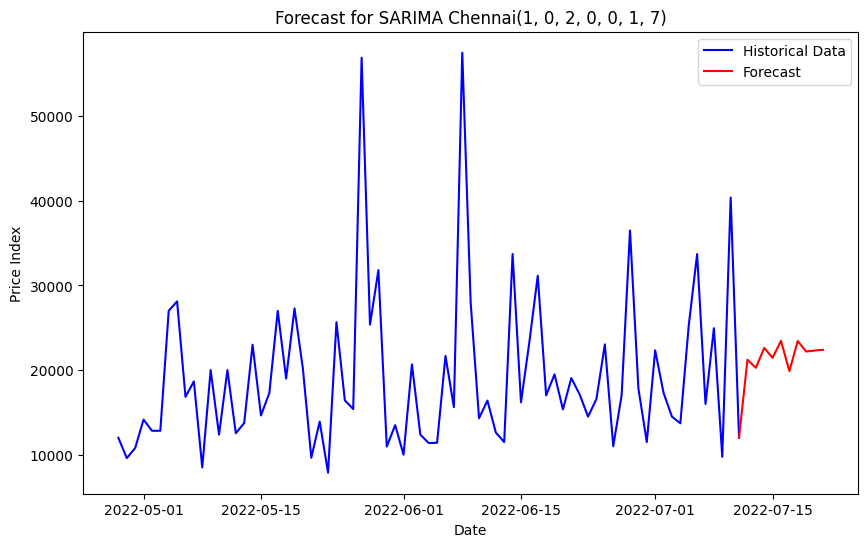

In [16]:
last_date = daily_price_index.index[-1]
forecast_index = pd.date_range(last_date + pd.Timedelta(days=1), periods=10, freq='D')

forecast_series = pd.Series([daily_price_index['price_index'].iloc[-1]] + list(forecast), 
                                     index=[daily_price_index.index[-1]] + list(forecast_index))

plt.figure(figsize=(10, 6))
plt.plot(daily_price_index.index, daily_price_index['price_index'], label="Historical Data", color='blue')

plt.plot(forecast_series.index, forecast_series, label="Forecast", color='red')

plt.title(f"Forecast for SARIMA Chennai{order_best_AIC}")
plt.xlabel("Date")
plt.ylabel("Price Index")
plt.legend()
plt.show()

/Users/masha/Desktop/Data mining (texas)/Data mining/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/masha/Desktop/Data mining (texas)/Data mining/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


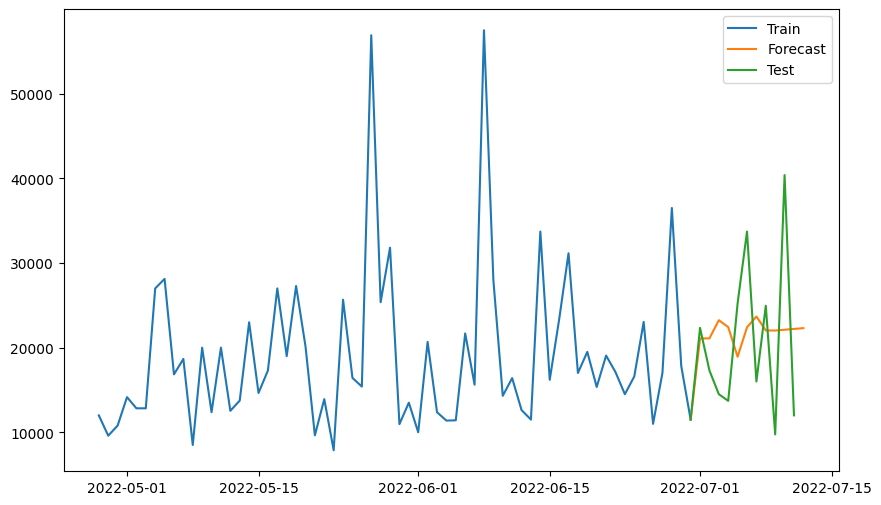

7716.652126015
80176964.40889768


In [17]:
train = daily_price_index['price_index'].iloc[:len(daily_price_index)-11]
test = daily_price_index['price_index'].iloc[len(daily_price_index)-12:]

model = SARIMAX(train, order=(order_best_AIC[0], order_best_AIC[1], order_best_AIC[2]),  
                seasonal_order=(order_best_AIC[3], order_best_AIC[4], order_best_AIC[5], order_best_AIC[6]),
                enforce_stationarity=False, enforce_invertibility=False) 
model_fit = model.fit()

fcast = model_fit.forecast(steps=len(test))

#We include the last point of the train set only for this graph so we have the continuous line on the plot
forecast_series = pd.Series([train.iloc[-1]] + list(fcast), index=[train.index[-1]] + list(fcast.index))

mae = mean_absolute_error(test, fcast)
mse = mean_squared_error(test, fcast)

plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(forecast_series, label='Forecast')
plt.plot(test, label='Test')
plt.legend()
plt.show()
print(mae)
print(mse)


/var/folders/8b/y9_jm73x12nb2_9y6tjxhg940000gq/T/ipykernel_72847/3739410407.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[0])
/var/folders/8b/y9_jm73x12nb2_9y6tjxhg940000gq/T/ipykernel_72847/3739410407.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[i]
/Users/masha/Desktop/Data mining (texas)/Data mining/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 90204823.38413201
Mean Absolute Error: 8342.608632193884


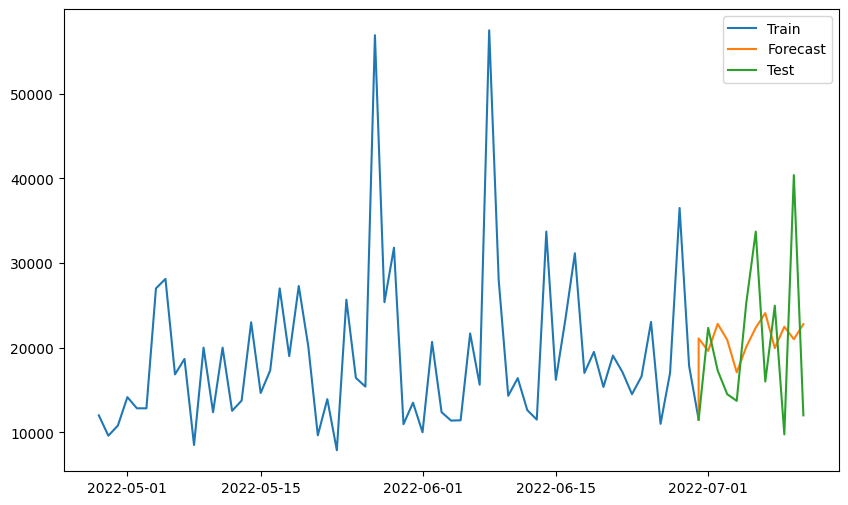

In [18]:
def rolling_forecast(train, test):
    '''
    Returns the forecast estimating an observation one period ahead, and then repeating this process for using the next t+1 observations to train the model.
    :param train: initial training set
    :param test: test set
    :return: forecasted observations
    '''
    
    history = [x for x in train]
    model = SARIMAX(history, order=(order_best_AIC[0], order_best_AIC[1], order_best_AIC[2]),  
                    seasonal_order=(order_best_AIC[3], order_best_AIC[4], order_best_AIC[5], order_best_AIC[6]),
                    enforce_stationarity=False, enforce_invertibility=False) 
    model_fit = model.fit()
    predictions = []
    results = {}
    yhat = model_fit.forecast()[0]

    predictions.append(yhat)
    history.append(test[0])
    for i in range(1, len(test)):
        model = SARIMAX(history, order=(order_best_AIC[0], order_best_AIC[1], order_best_AIC[2]),  
                seasonal_order=(order_best_AIC[3], order_best_AIC[4], order_best_AIC[5], order_best_AIC[6]),
                enforce_stationarity=False, 
                enforce_invertibility=False) 
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        obs = test[i]
        history.append(obs)
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    predictions = pd.Series(predictions, index=test.index)
    results['predictions'] = predictions
    results['mse'] = mse
    results['mae'] = mae
    return results

rolling_fcast = rolling_forecast(train, test)

forecast_series = pd.Series([train.iloc[-1]] + list(rolling_fcast['predictions']), index=[train.index[-1]] + list(rolling_fcast['predictions'].index))

plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(forecast_series, label='Forecast')
plt.plot(test, label='Test')

print(f'Mean Squared Error: {rolling_fcast["mse"]}')
print(f'Mean Absolute Error: {rolling_fcast["mae"]}')
plt.legend()
plt.show()